=== Baseline Model ===
Accuracy: 0.819672131147541
              precision    recall  f1-score   support

           0       0.76      0.90      0.83        29
           1       0.89      0.75      0.81        32

    accuracy                           0.82        61
   macro avg       0.83      0.82      0.82        61
weighted avg       0.83      0.82      0.82        61


=== GridSearchCV Model ===
Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
Accuracy: 0.8524590163934426
              precision    recall  f1-score   support

           0       0.83      0.86      0.85        29
           1       0.87      0.84      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61


=== RandomizedSearchCV Model ===
Best Parameters: {'classifier__n_estimators': 300, 'classifier__min_samples_split': 5

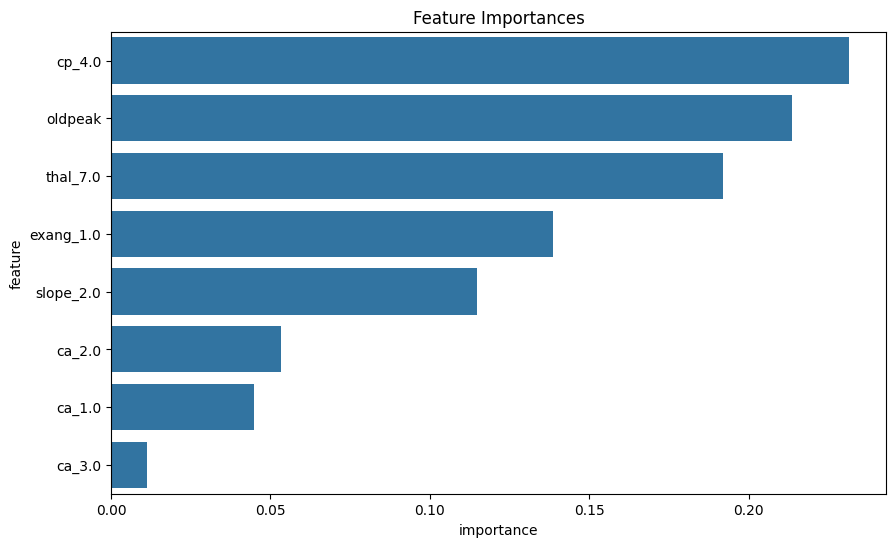

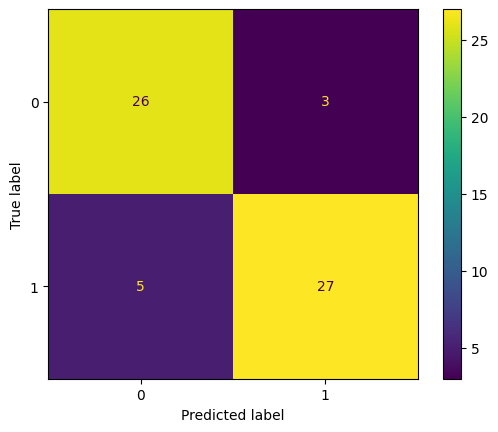

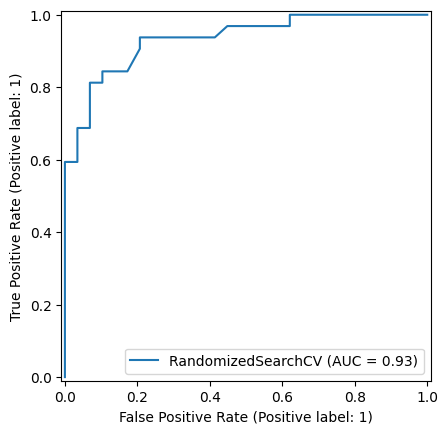

In [5]:
# 06_hyperparameter_tuning.ipynb (Fully Fixed for Pre-Encoded Features)

# 1️⃣ Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay

# 2️⃣ Load dataset
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/heart_disease_selected.csv")

# 3️⃣ Selected features
selected_features = ['oldpeak','cp_4.0','exang_1.0','slope_2.0','thal_7.0','ca_1.0','ca_2.0','ca_3.0']
target = 'target'

X = data[selected_features]
y = data[target]

# 4️⃣ Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5️⃣ Preprocessing (only scaling, since features are numeric)
preprocessor = Pipeline([
    ('scaler', StandardScaler())
])

# 6️⃣ Baseline model
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)

print("=== Baseline Model ===")
print("Accuracy:", accuracy_score(y_test, y_pred_baseline))
print(classification_report(y_test, y_pred_baseline))

# 7️⃣ GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(X_train, y_train)
y_pred_grid = grid_search.predict(X_test)

print("\n=== GridSearchCV Model ===")
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_grid))
print(classification_report(y_test, y_pred_grid))

# 8️⃣ RandomizedSearchCV
param_dist = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__max_depth': [None, 5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)
random_search.fit(X_train, y_train)
y_pred_random = random_search.predict(X_test)

print("\n=== RandomizedSearchCV Model ===")
print("Best Parameters:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_random))
print(classification_report(y_test, y_pred_random))

# 9️⃣ Compare models
results = pd.DataFrame({
    'Model': ['Baseline', 'GridSearchCV', 'RandomizedSearchCV'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_baseline),
        accuracy_score(y_test, y_pred_grid),
        accuracy_score(y_test, y_pred_random)
    ]
})
print("\n=== Model Comparison ===")
print(results)

# 10️⃣ Feature importance (best model)
best_model = random_search  # choose best performing model
importances = best_model.best_estimator_.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({'feature': selected_features, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title("Feature Importances")
plt.show()

# 11️⃣ Confusion matrix and ROC curve
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.show()

RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.show()

# 12️⃣ Save best model
joblib.dump(best_model, 'best_model.pkl')

# 13️⃣ Safe prediction function
def safe_predict(new_data_path, model_path='best_model.pkl'):
    """
    Predict safely on new data CSV with selected numeric features.
    """
    new_data = pd.read_csv(new_data_path)
    selected_features = ['oldpeak','cp_4.0','exang_1.0','slope_2.0','thal_7.0','ca_1.0','ca_2.0','ca_3.0']
    new_data = new_data[selected_features]
    model = joblib.load(model_path)
    preds = model.predict(new_data)
    return preds

# Example usage:
# predictions = safe_predict("new_data.csv")
# print(predictions)


In [7]:
import joblib
import os

# Create folder if it doesn't exist
save_path = '/content/drive/MyDrive/Colab Notebooks/Models'
os.makedirs(save_path, exist_ok=True)

# Save the best RandomizedSearchCV model
model_file = os.path.join(save_path, 'best_model.pkl')
joblib.dump(random_search, model_file)

print(f"✅ Best model saved to: {model_file}")



✅ Best model saved to: /content/drive/MyDrive/Colab Notebooks/Models/best_model.pkl
